## LCPB 24-25 Exercise 2 - Group 06

| Name              | email                                 | mat.    |
| ----------------- | ------------------------------------- | ------- |
| Corte Riccardo    | riccardo.corte@studenti.unipd.it      | 2160845 |
| Miotto Alessandro | alessandro.miotto.1@studenti.unipd.it | 2139205 |
| Rizzi Lorenzo     | lorenzo.rizzi.3@studenti.unipd.it     | 2156773 |

## 1) Hinton's choice on visible Bias Initialization 

The visible bias in a Restricted Boltzmann Machine (RBM) determines the likelihood of a visible unit (e.g., a pixel in an image) to be activated.  
Therefore, it represents the inherent tendency of visible variables to activate, independently of the initial input to the model.  

After being initially defined, the biases are constantly updated using gradient descent during the contrastive divergence procedure.  
In the single-step CD, the visible and hidden biases $a$ and $b$ are updated as follows:  


$\Delta a = \epsilon (v - v')$



$\Delta b = \epsilon (h - h')$


It is very important to accurately select the initial bias for the visible unit.  
This becomes evident when considering efficiency: initializing poorly the visible biases implies having to spend the early training iterations in order to adjust the hidden unit activation probability to match the training data.  
Proper initialization helps the hidden and visible units to adjust efficiently, enabling them to learn high-level details of the data.  

Hinton proposes in his publications to initialize the bias of the $i$-th visible unit as follows:  


$a_i = \log\left(\frac{p_i}{1 - p_i}\right)$


where $p_i$ is the proportion of training vectors in which the unit $i$ is active.  

This also prevents the early learning stage from being used merely to turn the visible unit on, which is why the initial bias is not set to zero. In this case since MNIST digits are sparse due to a black predominant background, this initialization helps avoid the vanishing gradient problem at the beginning.

We can intuitively understand this initialization method by considering that the goal is to reflect the data distribution with the initial biases.  
For example, setting all initial biases to zero would result in a uniform activation probability of **0.5** for all units, due to the sigmoid function, which does not match the actual proportion in the training data.  

Hinton's initialization strategy ensures that the initial activation probability is correctly weighted, aligning it on the training data distribution, allowing for a faster and optimal convergence of the biases.  






## 2) Computing the log-likelihood

We now aim to compute the log-likelihood for the RBM epoch by epoch. In this computations we use the values of biases and weights obtained from the training that has already been done using the given notebook. Such values have been stored locally in order to facilitate the computations and always use the same parameters for the analysis.

To compute the log-likelihood it is necessary to implement the following formula


$$L = \frac{1}{M} \sum_{m \leq M} \ell_{\theta}(x^{(m)})$$


$$\ell_{\theta}(x) = \ln \sum_{z} e^{-E(x, z)} - \ln \sum_{x'} \sum_{z} e^{-E(x', z)}$$

The first element of the equation depend on the energy function and therefore of the Boltzmann weight, all these elements are easilly computed using the weight and biases stored in memory.
The second element in the right side of the equation correspond to the partition function $Z$.

$$\ln Z = D \ln q + \ln \left( \sum_{z} G(z) \prod_{i=1}^{D} \left( \frac{1 + e^{H_i(z)}}{q} \right) \right)$$

Here we proceed similarly to before except for the computation of the parameter $q$.
This parameter is introdcued to compensate numerical instabilities related to the products of the terms $1 + e^{H_i(z)}$. It basically constitutes a scaling factor defined as a value close to the average of $1 + e^{H_i(z)}$ over all visible units i.
Conceptually the derivation of $q$ corresponds to calculate the average of $1 + e^{H_i(z)}$, and it will be done differently depending on the approach that we'll be using.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product


In [ ]:
# Load data from previous RBM training
a_data = np.load(f'./WEIGHTS/a_RBM_Potts_MNIST3_L3_RMSprop-0.01-0.001_Ep150_reg0.0001_POTTS_20250320_2249.npy')
b_data = np.load(f'./WEIGHTS/b_RBM_Potts_MNIST3_L3_RMSprop-0.01-0.001_Ep150_reg0.0001_POTTS_20250320_2249.npy')
w_data = np.load(f'./WEIGHTS/w_RBM_Potts_MNIST3_L3_RMSprop-0.01-0.001_Ep150_reg0.0001_POTTS_20250320_2249.npy')
data = np.load('./DATA/data.npy')

L = b_data.shape[1]         # hidden layer size
D = a_data.shape[1]         # visible layer size
M = data.shape[0]           # number of data samples
epoch = a_data.shape[0]     # number of epochs

print("Dataset size: N =", M)

print("\nEpoch:", epoch)
print("Visible layer size: D =", D)
print("Hidden layer size:  L =", L)

print("Shape of w_data: ", w_data.shape)    # should be 151 epochs * matrix(784,3)
print("Shape of a_data: ", a_data.shape)    # should be 151 epochs * vector(784)
print("Shape of b_data: ", b_data.shape)    # should be 151 epochs * vector(3)


Dataset size: N = 21770

Epoch: 151
Visible layer size: D = 784
Hidden layer size:  L = 3
Shape of w_data:  (151, 784, 3)
Shape of a_data:  (151, 784)
Shape of b_data:  (151, 3)


In [ ]:
likelihood = np.zeros(epoch)

for i in range(epoch):
    # Extract weights an biases from each epoch
    a = a_data[i]  # visible bias (D)
    b = b_data[i]  # hidden bias  (L)
    w = w_data[i]  # weights      (DxL)
    
    # Compute all possible configurations for hidden layer
    conf = list(product([0, 1], repeat=L))
    G_prod = 0
    q = 0
    for comb in conf:
        H = (a + np.dot(w, comb))                   # a vector (784,), for each neuron i

        # We have to fix q. We choose q as the characteristic value of H (mean) over the neurons x at a fixed combination of z (z = (0,0,0))
        if (comb == conf[0]):
            q = np.mean(1 + np.exp(H))
        
        prod = np.prod((1 + np.exp(H)) / q)
        G_exp = np.dot(b, comb) 
        G_prod += np.exp(G_exp) * prod
    
    lnZ = D * np.log(q) + np.log(G_prod)              # Being related to Z, this is not dependent of the single sample points, instead it's a global combinatorial property

    # Compute average likelihood in all data samples
    l = 0   # log-likelihood of each data sample
    for x in data:
        Eexp = 0
        for comb in conf:
            E = -np.dot(a, x) - np.dot(b, comb) - np.dot(x, np.dot(w, comb))
            Eexp += np.exp(-E)
        logE = np.log(Eexp)
        l += logE - lnZ    
    l /= M
    likelihood[i] = l
    print("Epoch:", i, "Likelihood:", l)


Although the likelihood computation was implemented using NumPy, we observed severe performance issues, particularly as the number of hidden layers increased. This is due to the summation over all possible hidden states, which results in $2^L$ different state. For $L=6$, the computation time reached nearly 16 minutes, making it impractical to test different hyperparameters efficiently.

Fortunately, since the weights and biases for each epoch are already computed during training, we leveraged CPU parallelization to improve performance. To achieve this we used the Numba library which, not only parallelizes the code, but also optimizes it through just-in-time (JIT) compilation. This required refactoring the code to explicitly define all loops. As a result, we reduced the computation time from 16 minutes to less than 30 seconds: a 32.3x performance improvement.

In [ ]:
from numba import jit, prange

likelihood = np.zeros(epoch)

# This needs to be outside of numba decl, cause apparently numba is not able to compile it (product is a global instance)
def computeCombination(SPINS:bool):
    if SPINS:
        conf = list(product([-1, 1], repeat=L))
    else:
        conf = list(product([0, 1], repeat=L))
    return conf

@jit(nopython=True, parallel = True)
def computeLikelihood(container, config, SPINS):
    for ep in prange(epoch):  
        # Extract weights an biases from each epoch
        a = a_data[ep]  # visible bias (D)
        b = b_data[ep]  # hidden bias  (L)
        w = w_data[ep]  # weights      (DxL)
    
        # we start by computing q. We define q_i as the characteristic value of 1 + exp(H_i(z)) over z. We won't take a mean over i.
        # This is to further improve the stability of the multiplication (we found out that by setting q as the mean of 1+exp(H_i(z)) over i and then over z
        # the likelihood was less stable
        q = np.zeros(D)  # a vector!
        for i in range(D):
            # inside this loop we are fixing the value of the visible neuron i
            # q(i) will be the exp. value of 1+exp(H_i(z)) over z
            qi = 0
            for comb2 in config:
                # we have to compute a single value of q
                prod_w_comb = 0
                for j in range(L):
                    prod_w_comb += w[i,j] * comb2[j]
                
                Hz = a[i] + prod_w_comb

                if (SPINS): 
                    qi += (np.exp(-Hz) + np.exp(Hz))
                else:
                    qi += (1 + np.exp(Hz))
            qi /= len(config)
            q[i] = qi

        # Next, we compute the logarithm of the partition function 
        G_prod = 0
        for comb in config:
            prod_w_comb = np.zeros(D)
            for i in range(D):
                for j in range(L):
                    prod_w_comb[i] += w[i,j] * comb[j]
        
            H = np.zeros(D)
            for i in range(D):
                H[i] += a[i] + prod_w_comb[i]  # a vector (784,), for each neuron i
            
            produc = 1
            for i in range(D):
                if (SPINS):
                    produc = produc * (2*np.cosh(H[i]))/q[i]
                else: 
                    produc = produc * (1 + np.exp(H[i])) / q[i]
                
            G_exp = 0
            for i in range(L):
                G_exp += b[i] * comb[i]

            G_prod += np.exp(G_exp) * produc

        # Note here that since q is dependent of i, we can not just add D*log(q) to the sum. We have to sum over the entries of vec(q)
        lnZ = np.sum(np.log(q)) + np.log(G_prod) 

        # Compute average likelihood in all data samples (i.e. the numerator of the likelihood)
        l = 0  # log-likelihood of each data sample
        for x in data:
            Eexp = 0
            for comb in config:
                E = 0
                for i in range(D):
                    E -= a[i] * x[i]
                    for j in range(L):
                        E -= w[i,j] * x[i] * comb[j]
                for i in range(L):
                    E -= b[i] * comb[i]
                Eexp += np.exp(-E)
            logE = np.log(Eexp)
            l += logE - lnZ    
        l /= M

        container[ep] = l
        print("Epoch:", ep, "Likelihood:", l)
    return container

likelihood = computeLikelihood(likelihood, computeCombination(False), SPINS = False)
# The output may appear messy, since the threads are not synchronized when printing to the console


### Plotting the likelihood over the epochs

Just for the sake of visualization, we have chosen L = 3 with CD = 2, to see whether the log-likelihood improved during the training.


We can see that the negative log-likelihood increases during training, this is an expected result. Conceptually the visible and hidden units represent a system of interacting particles whose state is defined by the energy function, training the RBM means adjusting the parameters so that the real data corresponds to states with minimal free energy, the high probability states. From the physical point of view we can thereore see that maximizing the log-likelihood corresponds to minimize the sistem's free energy.

In the figure we see that the log-likelihood is growing and therefore, starting from random weights the RBM is learning to assign higher probabilities to variables corresponding to real data points.

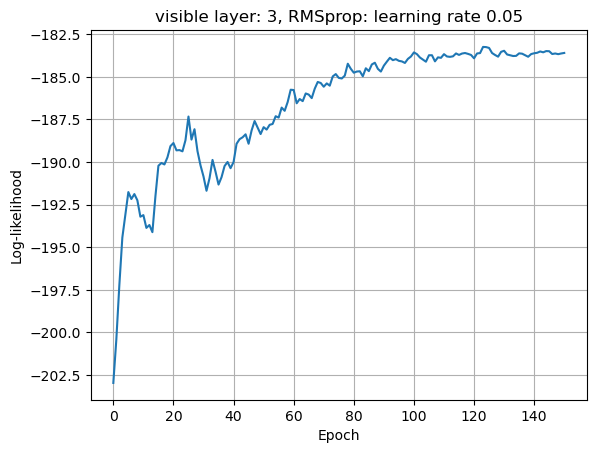

In [ ]:
plt.plot(likelihood)
plt.grid()
plt.title(f"visible layer: {L}, RMSprop: learning rate 0.05")
plt.xlabel("Epoch")
plt.ylabel("Log-likelihood")
plt.show()


In [ ]:
#np.save(f'./LIKELIHOOD/POTTS/L{L}_RMSprop_0.01_0.001_ep150_CD2_gamma0.0001.npy', likelihood)


## 3) Testing the RBM over different hyper-parameters

With the function previously defined we can calculate "vectors" of likelihood for different hyperparameters and save it in memory, the function will be here applied to analyze how the log-likelihood depends on the hyperparameters.


### 3.1) VARYING L

To understand how varying the number of hidden units affects the Log-Likelihood we must first briefly contestualize the role of hidden units. The hidden units can be seen as a latent representation of the data, capturing dependencies and patterns in the visible units, the inputs.
In this case we can Imagine that an hidden unit will be shaped in order to represent one of the three principal configuration corresponding to the numbers: "0","1","2".
Nonetheless having only three hidden units is conterinuitively sub optimal since in this case two hiddens gets usually wasted for representing the same number. It is therefore necessary to do a more complete analysis.

What we expect to obtain varying the number of hidden units is the following. For a small number of units we have too few parameters which results in a limit in the power of the model and therefore a low log-likelihood. Meanwhile having an excessively large number of hidden might result in overfitting or the instability of the learning procedure, ultimately reducing the Log-Likelihood.

This analysis is perfectly matched by the results obtained, the best configuration we get is the one with $L=6$, further increases of the hidden unit do not improve the results.

In [ ]:
likelihood_L = []
for i in range(3, 11):
    likelihood_L.append(np.load(f'./LIKELIHOOD/HIDDEN/L{i}_RMSprop_0.05_0.05_ep150.npy'))


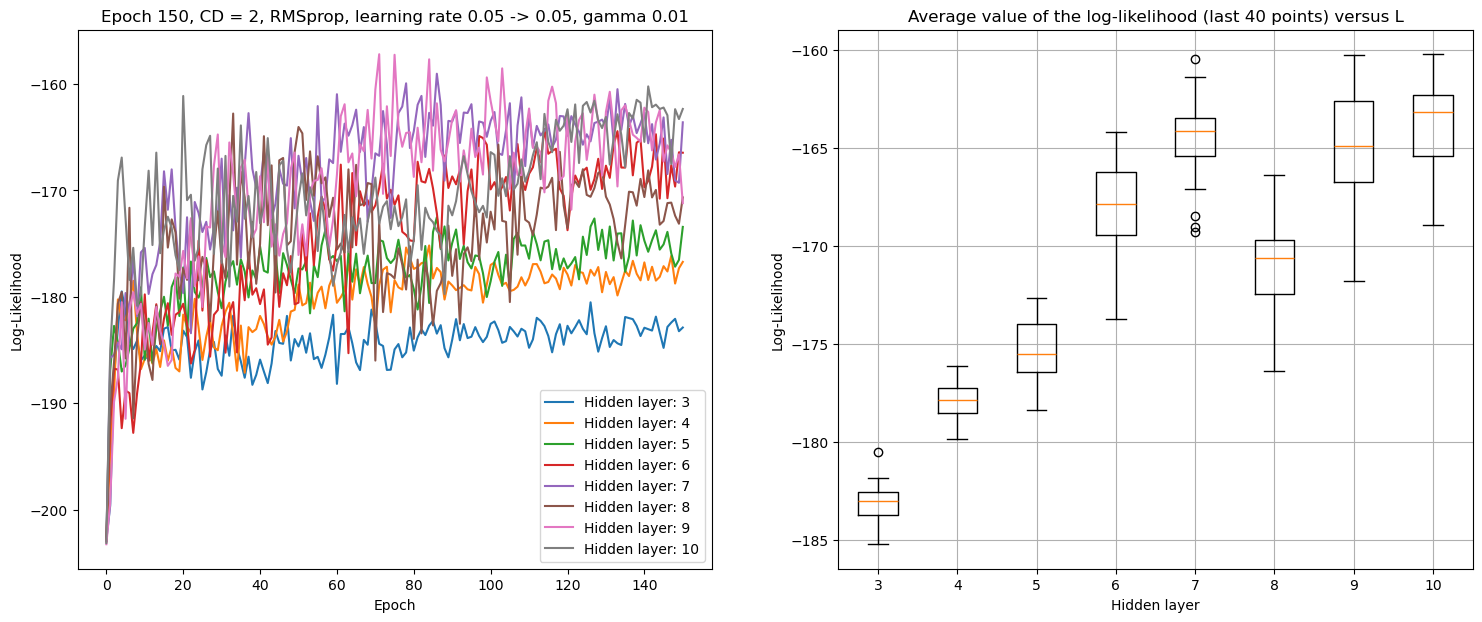

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize=(18,7))

for i, l in enumerate(likelihood_L):
    ax1.plot(l, label=f'Hidden layer: {i+3}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Log-Likelihood')
ax1.set_title('Epoch 150, CD = 2, RMSprop, learning rate 0.05 -> 0.05, gamma 0.01')
ax1.legend()


data = []
for i, l in enumerate(likelihood_L):
    d = l[-40:]
    data.append(d)

ax2.boxplot(data)
ax2.set_xlabel('Hidden layer')
ax2.set_ylabel('Log-Likelihood')
ax2.set_title("Average value of the log-likelihood (last 40 points) versus L")
ax2.set_xticklabels(range(3,11))
ax2.grid()

plt.show()


### 3.2) Varing contrastive divergence steps
We now see how the performance of the RBM changes as we vary some of its hyper-parameters. For instance, let us vary the CD order and keep as fixed all the other hyper-parameters of the architecture (such as the number of hidden layers, the learning rate, the optimizer, ...)


The choice of the value of CD determines how many Gibbs sampling steps are used to approximate the true distribution for the weights update. Despite using only a few steps of Gibbs sampling, the results appear comparable across different Contrastive Divergence (CD) steps. This may be because gradient descent does not require an exact direction, an approximate estimate, such as the one from CD-2, is sufficient to guide the optimization toward the correct minimization path.

In [ ]:
likelihood_CD = []
for i in range(2, 12, 2):
    likelihood_CD.append(np.load(f'./LIKELIHOOD/CD_STEPS/CD{i}_L6_RMSprop_0.05_0.05_ep150.npy'))


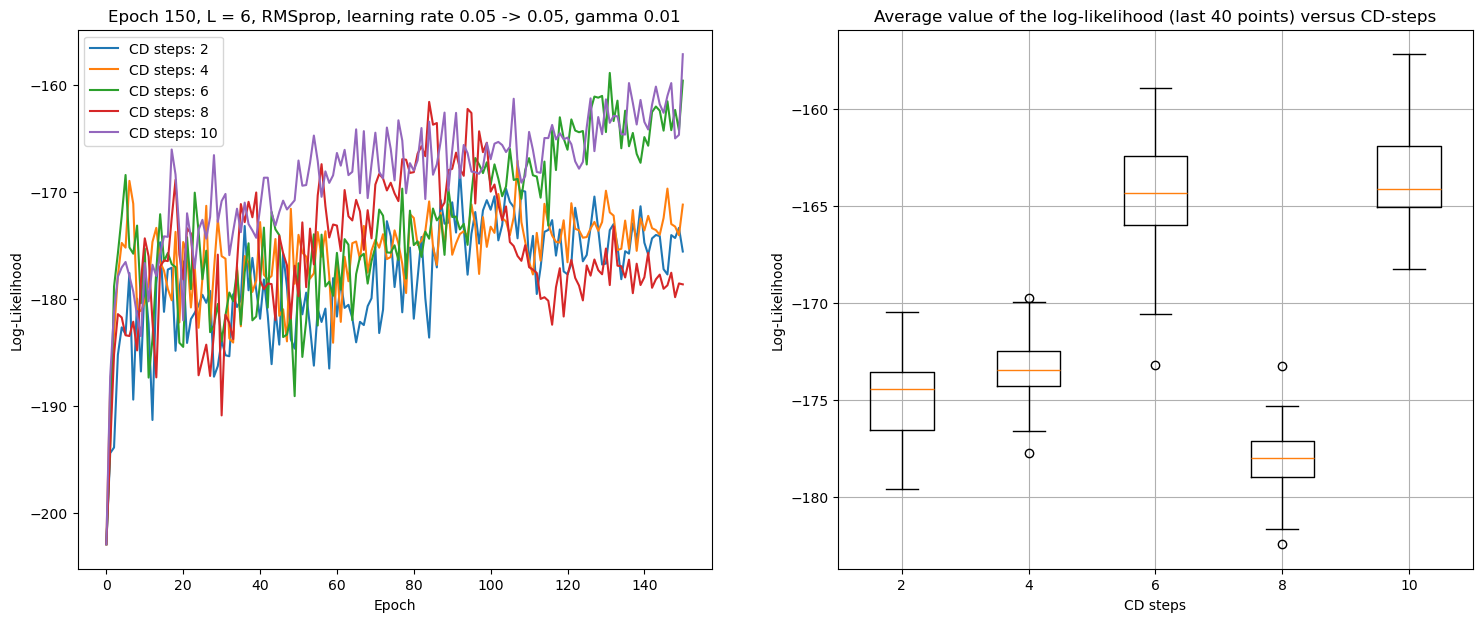

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize=(18,7))

for i, l in enumerate(likelihood_CD):
    ax1.plot(l, label=f'CD steps: {i*2+2}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Log-Likelihood')
ax1.set_title('Epoch 150, L = 6, RMSprop, learning rate 0.05 -> 0.05, gamma 0.01')
ax1.legend()


data = []
for i, l in enumerate(likelihood_CD):
    d = l[-40:]
    data.append(d)

ax2.boxplot(data)
ax2.set_xlabel('CD steps')
ax2.set_ylabel('Log-Likelihood')
ax2.set_title("Average value of the log-likelihood (last 40 points) versus CD-steps")
ax2.set_xticklabels(range(2, 12, 2))
ax2.grid()

plt.show()


### 3.3) Varing optimizer

This section compares standard stochastic gradient descent (SGD) and RMSprop. The results indicate that both methods yield similar performance, with a strong dependence on the initial and final learning rates. A linear decay schedule was applied to the learning rate.

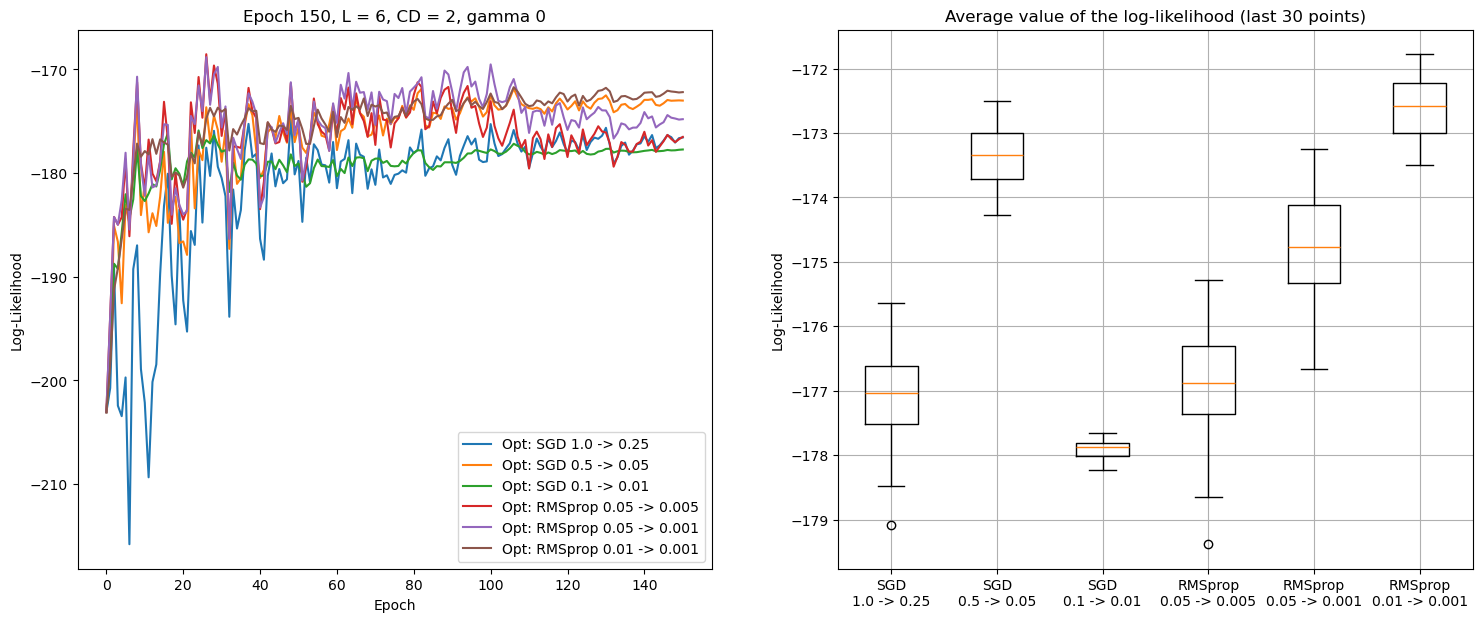

In [ ]:
likelihood_opt = []
likelihood_opt.append(np.load(f'./LIKELIHOOD/OPT/optSGD_L6_CD2_0.05_0.05_ep150.npy'))
likelihood_opt.append(np.load(f'./LIKELIHOOD/OPT/optSGD_L6_CD2_0.5_0.05_ep150.npy'))
likelihood_opt.append(np.load(f'./LIKELIHOOD/OPT/optSGD_L6_CD2_0.1_0.01_ep150.npy'))
likelihood_opt.append(np.load(f'./LIKELIHOOD/OPT/optRMSprop_L6_CD2_0.05_0.005_ep150.npy'))
likelihood_opt.append(np.load(f'./LIKELIHOOD/OPT/optRMSprop_L6_CD2_0.05_0.001_ep150.npy'))
likelihood_opt.append(np.load(f'./LIKELIHOOD/OPT/optRMSprop_L6_CD2_0.01_0.001_ep150.npy'))


fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize=(18,7))


ax1.plot(likelihood_opt[0], label=f'Opt: SGD 1.0 -> 0.25')
ax1.plot(likelihood_opt[1], label=f'Opt: SGD 0.5 -> 0.05')
ax1.plot(likelihood_opt[2], label=f'Opt: SGD 0.1 -> 0.01')
ax1.plot(likelihood_opt[3], label=f'Opt: RMSprop 0.05 -> 0.005')
ax1.plot(likelihood_opt[4], label=f'Opt: RMSprop 0.05 -> 0.001')
ax1.plot(likelihood_opt[5], label=f'Opt: RMSprop 0.01 -> 0.001')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Log-Likelihood')
ax1.set_title('Epoch 150, L = 6, CD = 2, gamma 0')
ax1.legend()


data = []
for i, l in enumerate(likelihood_opt):
    d = l[-40:]
    data.append(d)

ax2.boxplot(data)
ax2.set_ylabel('Log-Likelihood')
ax2.set_title("Average value of the log-likelihood (last 30 points)")
ax2.set_xticklabels(["SGD\n1.0 -> 0.25", "SGD\n0.5 -> 0.05", "SGD\n0.1 -> 0.01", "RMSprop\n0.05 -> 0.005", "RMSprop\n0.05 -> 0.001", "RMSprop\n0.01 -> 0.001"])
ax2.grid()

plt.show()


### 3.4) Varing LASSO regularization parameter $\gamma$

The goal of implementing regularization is to prevent overfitting by penalizing large weight values. The result is a limit in the weight magnitudes and the creation of a sparser, simpler model. The drawbacks for a regularization too large is an underfitting related to a failing in representing the data.

In the case of the MNIST dataset, which is already sparse, regularization tends to yield worse results in terms of log-likelihood. However, it is still important to understand its implications and benefits. Regularization helps produce "cleaner" weights, which can lead to more efficient and interpretable models. While this may come at the cost of a slight reduction in log-likelihood, it enhances generalization and stability, making the model more suitable for analysis.

As we can see, excessive regularization leads to poorer results due to over-constraining the model, which limits its ability to capture meaningful patterns in the data. Contrary, a smaller value of $\gamma$ enhance the model's ability to learn and improve the likelihood.

In [ ]:
likelihood_gamma = []
gamma = [0, 0.0001, 0.001, 0.01, 0.1]
for i in gamma:
    likelihood_gamma.append(np.load(f'./LIKELIHOOD/GAMMA/GAMMA{i}_L6_RMSprop_0.01_0.001_ep150.npy'))


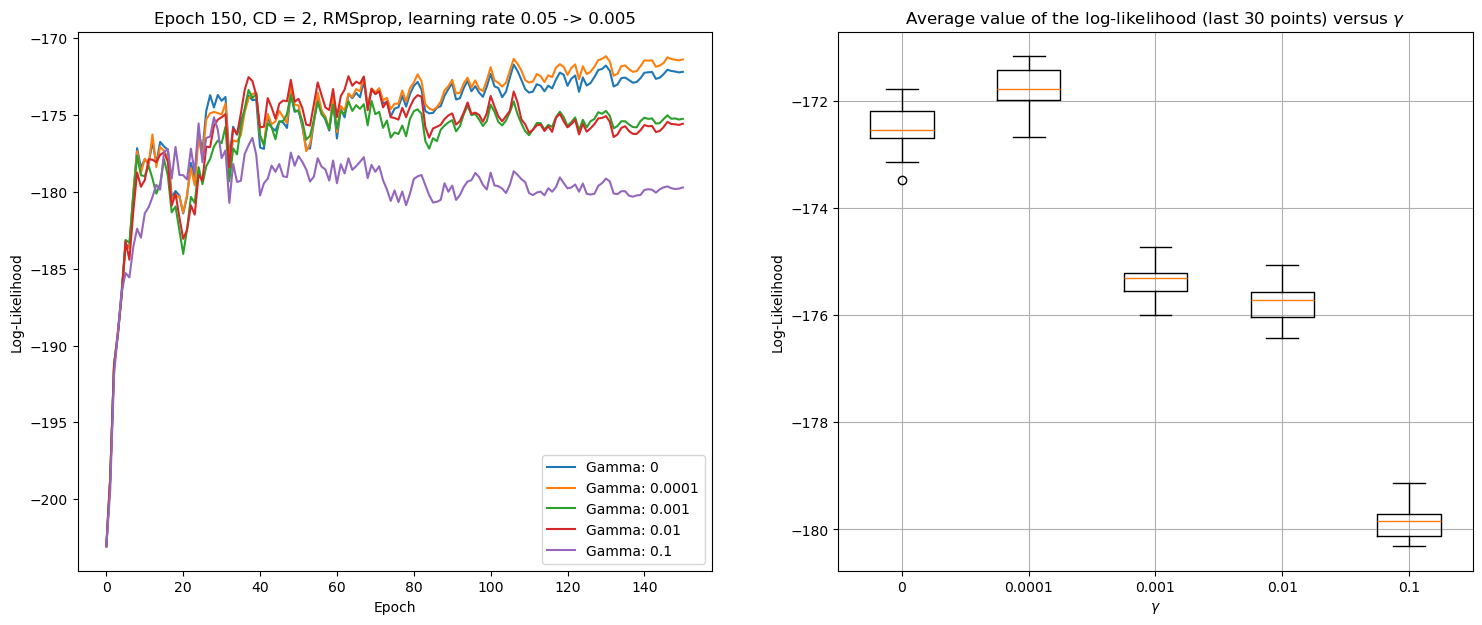

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize=(18,7))

for i, l in zip(gamma, likelihood_gamma):
    ax1.plot(l, label=f'Gamma: {i}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Log-Likelihood')
ax1.set_title('Epoch 150, CD = 2, RMSprop, learning rate 0.05 -> 0.005')
ax1.legend()


data = []
for i, l in enumerate(likelihood_gamma):
    d = l[-30:]
    data.append(d)

ax2.boxplot(data)
ax2.set_xlabel('$\\gamma$')
ax2.set_ylabel('Log-Likelihood')
ax2.set_title("Average value of the log-likelihood (last 30 points) versus $\\gamma$")
ax2.set_xticklabels(gamma)
ax2.grid()

plt.show()


### 3.5) Potts model

The Potts model is a generalization of the Ising model having $q$ possible states that corresponds to the number of hidden units. 
This model uses multinomial hidden units instead of binary ones, allowing to describe better more complex distribution but resulting in worse results for simpler binary models.
In the end for a binary model such as MNIST we expect standard RBMs to perform better.

Analyzing the result for the Log-Likelihood it is evident that this model performs sub optimally and that this higher level of complexity is not needed for the MNIST dataset.


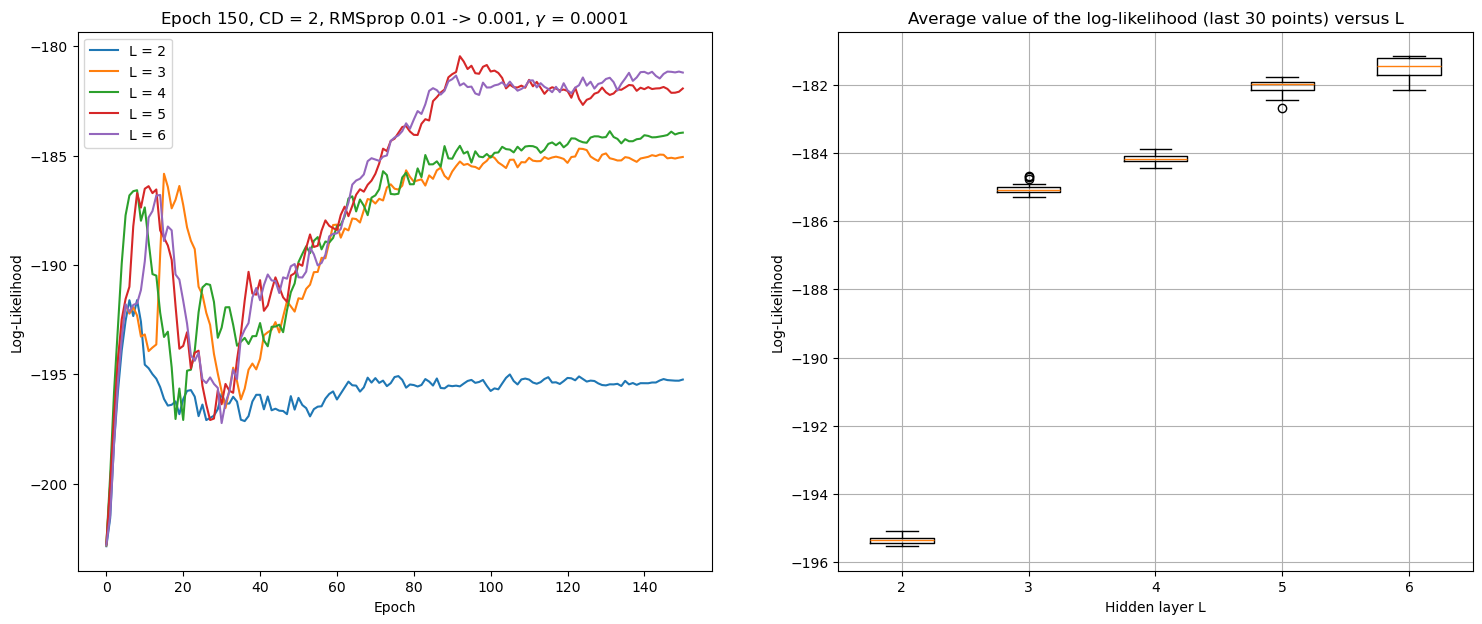

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize=(18,7))
for l in range(2,7):
    likelihood_potts = np.load(f'./LIKELIHOOD/POTTS/L{l}_RMSprop_0.01_0.001_ep150_CD2_gamma0.0001.npy')
    ax1.plot(likelihood_potts, label=f'L = {l}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Log-Likelihood')
ax1.set_title('Epoch 150, CD = 2, RMSprop 0.01 -> 0.001, $\\gamma$ = 0.0001')
ax1.legend()

data = []
for l in range(2,7):
    likelihood_potts = np.load(f'./LIKELIHOOD/POTTS/L{l}_RMSprop_0.01_0.001_ep150_CD2_gamma0.0001.npy')
    data.append(likelihood_potts[-30:])
ax2.boxplot(data)
ax2.set_xlabel('Hidden layer L')
ax2.set_ylabel('Log-Likelihood')
ax2.set_title("Average value of the log-likelihood (last 30 points) versus L")
ax2.set_xticklabels(list(range(2,7)))

ax2.grid()

plt.show()


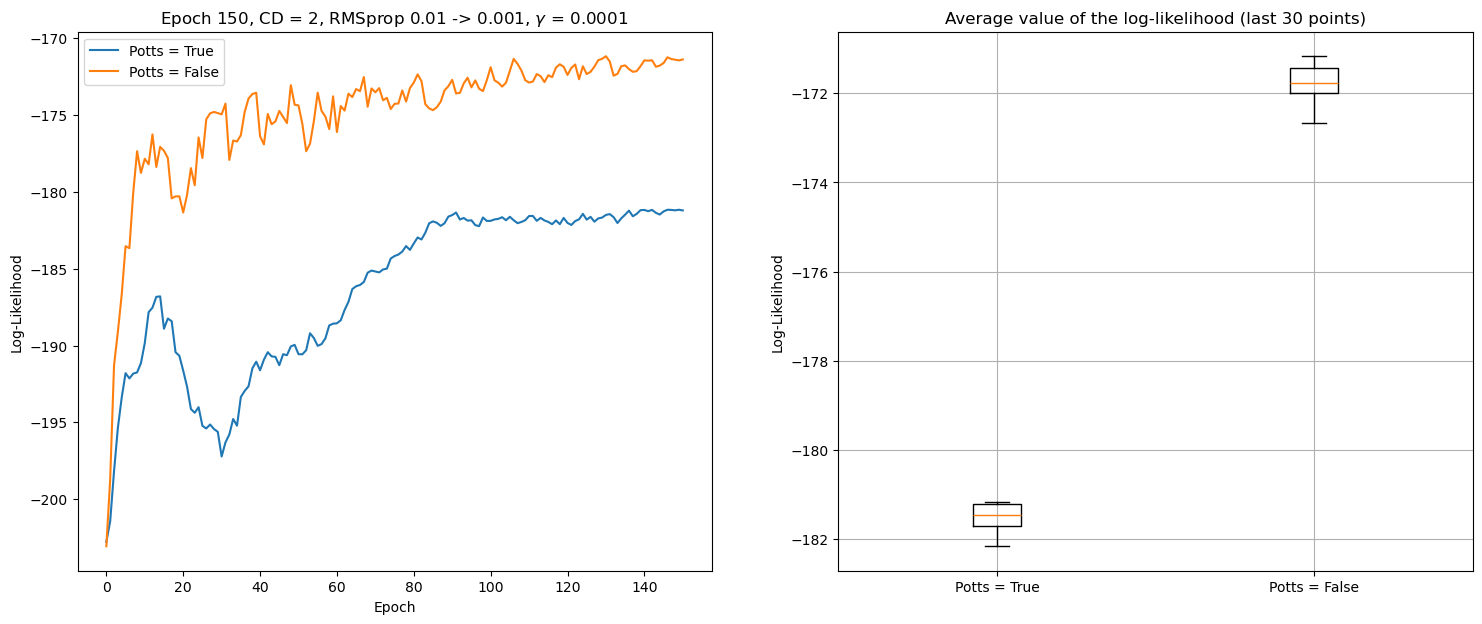

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize=(18,7))
likelihood_potts = np.load(f'./LIKELIHOOD/POTTS/L6_RMSprop_0.01_0.001_ep150_CD2_gamma0.0001.npy')
likelihood_no_potts = np.load(f'./LIKELIHOOD/GAMMA/GAMMA0.0001_L6_RMSprop_0.01_0.001_ep150.npy')
ax1.plot(likelihood_potts, label=f'Potts = True')
ax1.plot(likelihood_no_potts, label=f'Potts = False')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Log-Likelihood')
ax1.set_title('Epoch 150, CD = 2, RMSprop 0.01 -> 0.001, $\\gamma$ = 0.0001')
ax1.legend()

data = [likelihood_potts[-30:], likelihood_no_potts[-30:]]
ax2.boxplot(data)
ax2.set_ylabel('Log-Likelihood')
ax2.set_title("Average value of the log-likelihood (last 30 points)")
ax2.set_xticklabels(["Potts = True", "Potts = False"])

ax2.grid()

plt.show()


Using the option SPINS allows us to consider the variables as if they were Ising-like spins, thus using {-1, 1} instead of {0, 1} for the states..
The result obtained with this method are expected to be the same as the previous case since we are still considering a binomial model but are instead significantly worse.

A justification for this result can be found considering that by putting to -1 the hidden units this implies performing a computation and an update of the weight even for the neutral configuration, meanwhile puttinf $Z_{\mu}$ = 0 actively turns off the element that therefore doesn't waste computation power in the contrastive divergence. 
In the end, imposing to always activate the filters for all the MNIST elements ends up in a critical failure of the model, that doesn't converge.

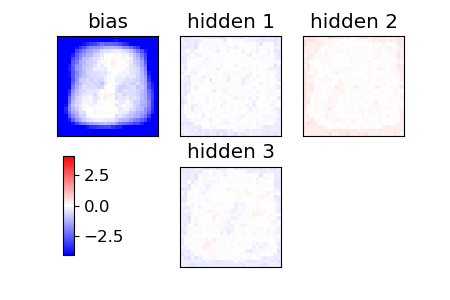

In [ ]:
from IPython.display import Image
Image(".//FIG/FRAME/RBM_150_w-a.png")
